In [1]:
# Imports
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import os, math
import numpy as np
import scipy.stats as st
import statistics
from scipy.fftpack import fft

# import scaleogram as scg
# import pywt
from datetime import datetime

import time

In [2]:
def my_rms(acc):
    return np.sqrt(np.mean(acc**2))

def my_kurt(acc):
    return st.kurtosis(acc, fisher=False)

# def my_var(acc):
#     return statistics.variance(acc)

# def my_pkpk(acc):
#     return np.amax(acc)-np.amin(acc)

# def my_skew(acc):
#     return st.skew(acc)

# def feature_extraction(data):
#     return np.array([np.apply_along_axis(my_rms, 0, data),
#                      np.apply_along_axis(my_var, 0, data),
#                      np.apply_along_axis(my_pkpk, 0, data),
#                      np.apply_along_axis(my_kurt, 0, data),
#                      np.apply_along_axis(my_skew, 0, data)]).reshape(40)

def extract_data(path, config, step_window = 10):
    files_list = os.listdir(path)

    rms = []
    kurtosis = []
    for file in files_list:  # [:3]:
        data = pd.read_csv(path+file, sep='\t', header=None)
        rms.append(my_rms(data))
        kurtosis.append(my_kurt(data))
        
    rms = np.array(rms)
    kurtosis = np.array(kurtosis)
    rms = rms[:,config].copy()
    kurtosis = kurtosis[:,config].copy()
    
    partial_rmsee = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    for j in range(len(rms) - (step_window - 1)):
        step_rmsee = 0.0
        for i in range(step_window):
            step_rms = rms[j + i]
            step_rmsee += -step_rms*math.log(step_rms)
        step_rmsee /= step_window
        partial_rmsee.append(step_rmsee)

    rmsee = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    for j in range(len(partial_rmsee) - (step_window - 1)):
        step_mean_rmsee = 0.0
        for i in range(step_window):
            step_mean_rmsee += partial_rmsee[j + i]
        step_mean_rmsee /= step_window
        rmsee.append(step_mean_rmsee)
        
    return rms, kurtosis, rmsee

In [3]:
rms_train, kurtosis_train, rmsee_train = extract_data('C:/Users/HPUSER/Documents/Projetos/neoprog/2nd_test/', 0)

In [4]:
def ufrf(t, b, n, y, k):
    return y+(k*(b/(n**b))*(t**(b-1)))

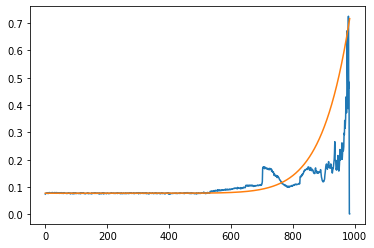

In [35]:
ufrf_rms = []
for i in range(len(rms_train)):
    ufrf_rms.append(ufrf(i, 12.0917, 281.0209, 0.0773, 1.38e-5))

ufrf_rms = np.array(ufrf_rms)
plt.plot(rms_train)
plt.plot(ufrf_rms)

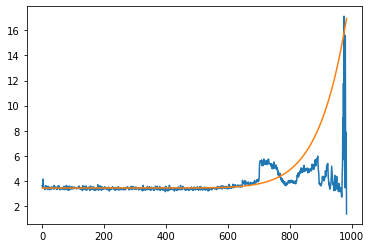

In [36]:
ufrf_kurtosis = []
for i in range(len(kurtosis_train)):
    ufrf_kurtosis.append(ufrf(i, 11.8280, 86.7537,  3.4471, 3.8e-10))

ufrf_kurtosis = np.array(ufrf_kurtosis)
plt.plot(kurtosis_train)
plt.plot(ufrf_kurtosis)

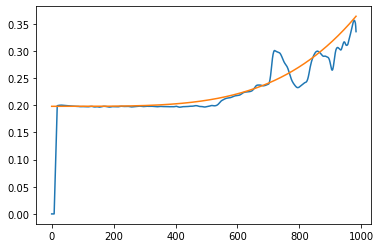

In [30]:
ufrf_rmsee = []

for i in range(len(rmsee_train)):
    ufrf_rmsee.append(ufrf(i, 5.0,  100.0, 0.19796, 3.55e-4))

ufrf_rmsee = np.array(ufrf_rmsee)
plt.plot(rmsee_train)
plt.plot(ufrf_rmsee)

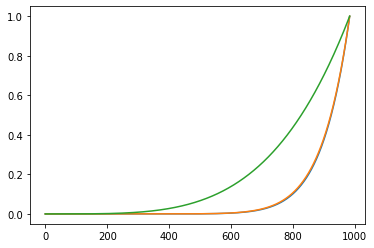

In [52]:
def norm(vector, vector_min, vector_max):
    return (vector - vector_min) / (vector_max - vector_min)

def bound(vector):
    for i in range(len(vector)):
        if vector[i] > 1.0:
            vector[i] = 1.0
        elif vector[i] < 0.0:
            vector[i] = 0.0
    return vector

rms_min = ufrf_rms.min()
rms_max = ufrf_rms.max()
norm_ufrf_rms = norm(ufrf_rms, rms_min, rms_max) 
kurtosis_min = ufrf_kurtosis.min()
kurtosis_max = ufrf_kurtosis.max()
norm_ufrf_kurtosis = norm(ufrf_kurtosis, kurtosis_min, kurtosis_max)
rmsee_min = ufrf_rmsee.min()
rmsee_max = ufrf_rmsee.max()
norm_ufrf_rmsee = norm(ufrf_rmsee, rmsee_min, rmsee_max)

plt.plot(norm_ufrf_rms)
plt.plot(norm_ufrf_kurtosis)
plt.plot(norm_ufrf_rmsee)

In [38]:
len_train = len(rms_train)
X = []
y = []

for i in range(len_train - 1):
    label = 0
    current_label = i / len_train
    if current_label < 0.1:
        label = 0
    elif current_label < 0.25:
        label = 1
    elif current_label < 0.4:
        label = 2
    elif current_label < 0.55:
        label = 3
    elif current_label < 0.7:
        label = 4
    elif current_label < 0.85:
        label = 5
    else:
        label = 6
    y.append(label)
    X.append([norm_ufrf_rms[i], norm_ufrf_rms[i+1], norm_ufrf_kurtosis[i], norm_ufrf_kurtosis[i+1], norm_ufrf_rmsee[i], norm_ufrf_rmsee[i+1]])


In [39]:
def complement_code(X):
        I = np.hstack((X, 1-X))
        return I

def minimum(A,B):
    ans=[]
    for i in range(len(A)):
        #print("I and W sizes: ", len(A), len(B))
#         print(A)
#         print(A[i])
#         print(B)
#         print(B[i])
        ans.append(min([A[i],B[i]]))
        
    ans = np.array(ans)
    return ans

class Simplified_fuzzy_ARTMAP:
    def __init__(self, X_size, label_size, c_max_a, rho_a, rho_ab, alpha=0.00001, beta=1):
        self.M_a = X_size    # input vector size
        self.M_ab = label_size    # input label vector size
        
        self.c_max_a = c_max_a # max categories for ART-a
        
        
        self.rho_a = rho_a    # vigilance parameter for ART-a
        self.rho_a_baseline = rho_a
        self.rho_ab = rho_ab  # vigilance parameter for map field
        self.alpha = alpha # choice parameter
        self.beta = beta   # learning rate
        
        self.N_a = 0         # no. of categories of ART_a initialized to zero
        
        self.W_a = np.ones( (c_max_a, self.M_a*2) ) # initialize W_a with 1s
        self.W_ab = np.ones( (self.M_ab, c_max_a) ) # initialize W_ab with 1s
        
        self.X_ab = np.zeros( (self.M_ab,) )
    
    def train(self, X, one_hot_labels, rho_a_inc_rate=0.001):
        A = complement_code(X)   # shape of X = Mx1, shape of I = 2Mx1
        B = one_hot_labels
         
        self.rho_a =  self.rho_a_baseline
         
        T = []
        for i in range(self.N_a):           
            T.append( np.sum(minimum(A,self.W_a[i,:])) / (self.alpha+np.sum(self.W_a[i,:])) ) # calculate output
        
        J_list = np.argsort(np.array(T))[::-1]  # J_list: indices of F2 nodes with decreasing order of activations        
        
        for J in J_list:
            # Checking for resonance in ART-a  ---
            X_a_mod = np.sum(minimum(A,self.W_a[J,:])) 
                
            while X_a_mod >= self.rho_a * np.sum(A): # resonance occured in ART-a 
                
                #####  match tracking  #####
                # Checking for resonance in the MAP FIELD  ---
                   
                self.X_ab_mod = np.sum( minimum( B,self.W_ab[:,J] ) )
                
                if self.X_ab_mod > self.rho_ab * np.sum(B): # resonance occurs in the MAP FIELD
                    # weight update
                    self.W_a[J,:] = self.beta*minimum(A,self.W_a[J,:]) + (1-self.beta)*self.W_a[J,:] # weight update of ART-a
                    K = np.argmax( B )
                    self.W_ab[:,J] = 0
                    self.W_ab[K,J] = 1
                    return self.W_ab, K
                
                else: # NO resonance in the MAP FIELD
                    self.rho_a += rho_a_inc_rate
       
        if self.N_a < self.c_max_a:    # no resonance occured in ART-a, create a new category
            n = self.N_a
            self.W_a[n,:] = self.beta*minimum(A,self.W_a[n,:]) + (1-self.beta)*self.W_a[n,:] # weight update
            self.N_a += 1
            
            K = np.argmax( B )
            self.W_ab[:,n] = 0
            self.W_ab[K,n] = 1
            return self.W_ab, K
        
        if self.N_a >= self.c_max_a:
            print("ART-a memory error!")
            return None, None
    
    def infer(self, X):
        A = complement_code(X)   
        T = []
        for i in range(self.N_a):           
            T.append( np.sum(minimum(A,self.W_a[i,:])) / (self.alpha+np.sum(self.W_a[i,:])) ) # calculate output        
        #J_list = np.argsort(np.array(T))[::-1]  # J_list: indices of F2 nodes with decreasing order of activations        
        #J = J_list[0] # maximum activation
        J = np.argmax(np.array(T))
        X_ab = self.W_ab[:,J] 
        return X_ab

sfam = Simplified_fuzzy_ARTMAP(6, 7, 7, 0.0005, 0.00005)

for i in range(len(X)):
    print(i, y[i])
    sfam.train(np.array(X[i]), np.array([y[i]]))

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
ART-a memory error!
8 0
ART-a memory error!
9 0
ART-a memory error!
10 0
ART-a memory error!
11 0
ART-a memory error!
12 0
ART-a memory error!
13 0
ART-a memory error!
14 0
ART-a memory error!
15 0
ART-a memory error!
16 0
ART-a memory error!
17 0
ART-a memory error!
18 0
ART-a memory error!
19 0
ART-a memory error!
20 0
ART-a memory error!
21 0
ART-a memory error!
22 0
ART-a memory error!
23 0
ART-a memory error!
24 0
ART-a memory error!
25 0
ART-a memory error!
26 0
ART-a memory error!
27 0
ART-a memory error!
28 0
ART-a memory error!
29 0
ART-a memory error!
30 0
ART-a memory error!
31 0
ART-a memory error!
32 0
ART-a memory error!
33 0
ART-a memory error!
34 0
ART-a memory error!
35 0
ART-a memory error!
36 0
ART-a memory error!
37 0
ART-a memory error!
38 0
ART-a memory error!
39 0
ART-a memory error!
40 0
ART-a memory error!
41 0
ART-a memory error!
42 0
ART-a memory error!
43 0
ART-a memory error!
44 0
ART-a memory error!
45 0
ART-a memory error!


In [40]:
for i in range(len(X)):
    print(sfam.infer(np.array(X[i])))

[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0

[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0

[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0

In [44]:
from sklearn.neural_network import MLPClassifier

m = MLPClassifier(hidden_layer_sizes=(171), activation = 'identity', solver = 'lbfgs')
m.fit(X, y)
p = m.predict(X)
for i in range(len(p)):
    print(i, p[i], p[i] == y[i])

c:\users\hpuser\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



0 0 True
1 0 True
2 0 True
3 0 True
4 0 True
5 0 True
6 0 True
7 0 True
8 0 True
9 0 True
10 0 True
11 0 True
12 0 True
13 0 True
14 0 True
15 0 True
16 0 True
17 0 True
18 0 True
19 0 True
20 0 True
21 0 True
22 0 True
23 0 True
24 0 True
25 0 True
26 0 True
27 0 True
28 0 True
29 0 True
30 0 True
31 0 True
32 0 True
33 0 True
34 0 True
35 0 True
36 0 True
37 0 True
38 0 True
39 0 True
40 0 True
41 0 True
42 0 True
43 0 True
44 0 True
45 0 True
46 0 True
47 0 True
48 0 True
49 0 True
50 0 True
51 0 True
52 0 True
53 0 True
54 0 True
55 0 True
56 0 True
57 0 True
58 0 True
59 0 True
60 0 True
61 0 True
62 0 True
63 0 True
64 0 True
65 0 True
66 0 True
67 0 True
68 0 True
69 0 True
70 0 True
71 0 True
72 0 True
73 0 True
74 0 True
75 0 True
76 0 True
77 0 True
78 0 True
79 0 True
80 0 True
81 0 True
82 0 True
83 0 True
84 0 True
85 0 True
86 0 True
87 0 True
88 0 True
89 0 True
90 0 True
91 0 True
92 0 True
93 0 True
94 0 True
95 0 True
96 0 True
97 0 True
98 0 True
99 0 False
100 0 Fal

756 5 True
757 5 True
758 5 True
759 5 True
760 5 True
761 5 True
762 5 True
763 5 True
764 5 True
765 5 True
766 5 True
767 5 True
768 5 True
769 5 True
770 5 True
771 5 True
772 5 True
773 5 True
774 5 True
775 5 True
776 5 True
777 5 True
778 5 True
779 5 True
780 5 True
781 5 True
782 5 True
783 5 True
784 5 True
785 5 True
786 5 True
787 5 True
788 5 True
789 5 True
790 5 True
791 5 True
792 5 True
793 5 True
794 5 True
795 5 True
796 5 True
797 5 True
798 5 True
799 5 True
800 5 True
801 5 True
802 5 True
803 5 True
804 5 True
805 5 True
806 5 True
807 5 True
808 5 True
809 5 True
810 5 True
811 5 True
812 5 True
813 5 True
814 5 True
815 5 True
816 5 True
817 5 True
818 5 True
819 5 True
820 5 True
821 5 True
822 5 True
823 5 True
824 5 True
825 5 True
826 5 True
827 5 True
828 5 True
829 5 True
830 5 True
831 5 True
832 5 True
833 5 True
834 5 True
835 5 True
836 5 True
837 6 True
838 6 True
839 6 True
840 6 True
841 6 True
842 6 True
843 6 True
844 6 True
845 6 True
846 6 True

In [45]:
# import optuna
# import sklearn
# import sklearn.datasets
# import sklearn.neural_network

# # x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)

# def objective(trial):

#     n_layers = trial.suggest_int('n_layers', 1, 6)
#     layers = []
#     for i in range(n_layers):
#         layers.append(trial.suggest_int(f'n_units_{i}', 1, 200))

#     activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
#     solver = trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam'])
    
#     clf = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=tuple(layers), activation = activation, solver=solver)
#     clf.fit(X, y)

#     return clf.score(X, y)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=1000)

# # Trial 108 finished with value: 0.9959308240081384 and parameters: {'n_layers': 1, 'n_units_0': 171, 'activation': 'identity', 'solver': 'lbfgs'}. Best is trial 108 with value: 0.9959308240081384.

In [46]:
rms_test, kurtosis_test, rmsee_test = extract_data('C:/Users/HPUSER/Documents/Projetos/neoprog/1st_test/', 4)

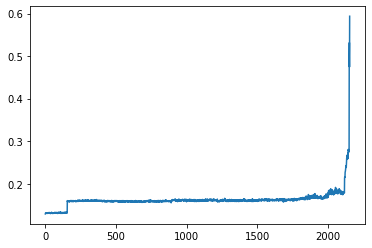

In [47]:
plt.plot(rms_test)

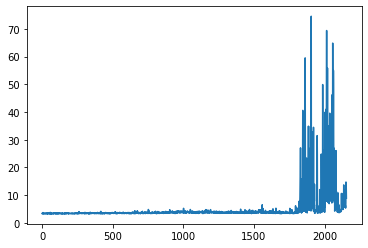

In [48]:
plt.plot(kurtosis_test)

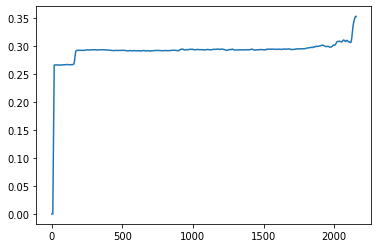

In [49]:
plt.plot(rmsee_test)

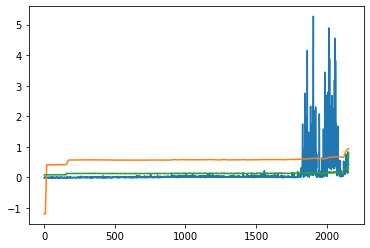

In [51]:
norm_rms_test = norm(rms_test, rms_min, rms_max) 
norm_kurtosis_test = norm(kurtosis_test, kurtosis_min, kurtosis_max)
norm_rmsee_test = norm(rmsee_test, rmsee_min, rmsee_max)

plt.plot(norm_rms_test)
plt.plot(norm_kurtosis_test)
plt.plot(norm_rmsee_test)

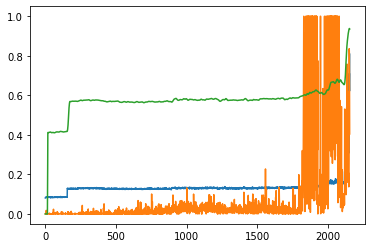

In [53]:
norm_rms_test = bound(norm_rms_test)
norm_kurtosis_test = bound(norm_kurtosis_test)
norm_rmsee_test = bound(norm_rmsee_test)

plt.plot(norm_rms_test)
plt.plot(norm_kurtosis_test)
plt.plot(norm_rmsee_test)

In [25]:
def smoothing(y, si = 6):
    result = []
    ss = 0
    rul = 0
    for i in range(len(y)):
        if ss == si:
            rul = y[i]
            ss = 0
        else:
            rul = (rul + y[i]) / 2
            ss += 1
        result.append(rul)
    return result

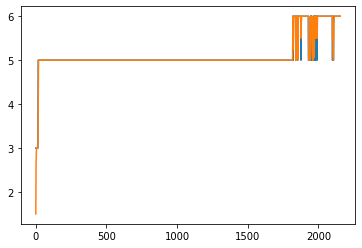

In [55]:
test_len = len(rms_test)
test_input = []
for i in range(test_len - 1):
    test_input.append([norm_rms_test[i], norm_rms_test[i+1], norm_kurtosis_test[i], norm_kurtosis_test[i+1], norm_rmsee_test[i], norm_rmsee_test[i+1]])

p = m.predict(test_input)
plt.plot(p)
plt.plot(smoothing(p))